In [1]:
import gym
import numpy as np
import random
import torch
import time
from itertools import count


from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('Pendulum-v0')

In [3]:
env.action_space

Box(1,)

In [4]:
env.observation_space

Box(3,)

In [5]:
env.reset()
for i in range(500):
    env.render()
    env.step(env.action_space.sample())
env.close()

In [92]:
env.close()
env.reset()

array([-0.69096088, -0.72289215, -0.85411969])

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [6]:
class OUNoise:
    """docstring for OUNoise"""
    def __init__(self, action_dimension, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [7]:
from collections import deque

class Memory():
    def __init__(self, capacity=10000, short_capacity=2000):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)
        self.short_memory = deque(maxlen=short_capacity)
        
    def push(self, old_state, action, reward, new_state, final):
        self.short_memory.append([old_state, action, reward, new_state, final])
        
    def commit(self, final=True): 
        
        self.short_memory[-1][-1] = final
        
#         R = self.short_memory[-1][2]
#         for i in range(len(self.short_memory) - 1):
#             R = self.short_memory[-2 -i][2] + R*0.99
#             self.short_memory[-2 -i][2] = R
        
        self.memory.extendleft(self.short_memory)

                
#         self.memory = self.memory[-self.capacity:]
        self.short_memory.clear()

In [19]:
class Actor_net(torch.nn.Module):
    def __init__(self):
        super(Actor_net, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(6, 32),
            torch.nn.LeakyReLU(inplace=True),
#             torch.nn.Dropout(p=0.2),
            
            torch.nn.Linear(32, 32),
            torch.nn.LeakyReLU(inplace=True),
#             torch.nn.Dropout(p=0.2),
            
            torch.nn.Linear(32, 1),
            torch.nn.Tanh(),
#             torch.nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)#.clamp(-1, 1)
    
class Qritic_net(torch.nn.Module):
    def __init__(self):
        super(Qritic_net, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(6, 32),
            torch.nn.LeakyReLU(),
#             torch.nn.Dropout(p=0.2),
            
            torch.nn.Linear(32, 32),
            torch.nn.LeakyReLU(),
#             torch.nn.Linear(32, 32),
#             torch.nn.LeakyReLU(),
        )
        
        self.head = torch.nn.Sequential(
            torch.nn.Linear(32 + 1, 32),
            torch.nn.LeakyReLU(),
#             torch.nn.Dropout(p=0.2),
            
            torch.nn.Linear(32, 1),
        )
    
    def forward(self, state, actions):
        out = self.model(state)
        out = torch.cat((out, actions), dim=1)
        out = self.head(out)
        return out

policy_actor, policy_critic = Actor_net().to(device), Qritic_net().to(device)
target_actor, target_critic = Actor_net().to(device), Qritic_net().to(device)

target_actor.load_state_dict(policy_actor.state_dict())
target_critic.load_state_dict(policy_critic.state_dict())

In [20]:
critic_optim = torch.optim.Adam(policy_critic.parameters(), lr=0.003)
# actor_optim = torch.optim.Adam(policy_actor.parameters(), lr=0.001)
actor_optim = torch.optim.SGD(policy_actor.parameters(), lr=0.02)
# optim = torch.optim.SGD(policy_net.parameters(), lr=0.001)

# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optim, step_size=100, gamma=0.84)    

In [21]:
# %%prun
# env = gym.make('CartPole-v0')
env._max_episode_steps = 100

EPS = 3
EPS_MIN = 0.01
GAMMA = 0.999
c = 0

noise = OUNoise(1)

t0 = None

def get_model_action(model, state, device, train=True):
    global EPS, EPS_MIN, GAMMA, noise
    EPS = EPS * GAMMA
    EPS = max(EPS, EPS_MIN)
    
#     if random.random() < EPS:
#         action = random.random() * 2
#         action -= 1
#         return [action]
    
#     if train and random.random() < 0.2:
#         return [0]
    
    with torch.no_grad():
        model.eval()
        model_output = model(torch.FloatTensor(state).to(device).unsqueeze(0)).cpu().detach().numpy()
        action = model_output[0]
#         action = np.clip(action, -1.0, 1.0)
        
#         action += EPS * noise.noise()
#         action += (random.random() * 2 - 1) * 2 * EPS
        action = action + noise.noise() * EPS
        action = np.clip(action, -1.0, 1.0)
        
#             print(state, model_output, action)
        
#     global c
#     c += 1
#     if c < 30:
#         print(action)
#     if random.random() < 0.0003:
#         print('action', action, 'eps', EPS)
        
    return action
    
    if train:
        
        action = np.clip(action, -1, 1)
        noise = (random.random() * 2) -1
        noise = noise * EPS  * 2
        action = action + noise
        action = np.clip(action, -1, 1)

    
    return action

c_loss = []
a_loss = []

def train(memory, device):
    memory = memory.memory
    try:
        memory = random.sample(memory, 1024)
    except ValueError:
        return

#     s0 = [x[0] for x in memory]
#     a = [x[1] for x in memory]
#     r = [[x[2]] for x in memory]
#     s1 = [x[3] for x in memory]
#     done = [1. if x[4] else 0. for x in memory]
    
    s0, a, r, s1, done = zip(*memory)


    s0 = torch.FloatTensor(s0).to(device)
    s1 = torch.FloatTensor(s1).to(device)
    a = torch.FloatTensor(a).to(device)
    r = torch.FloatTensor(r).unsqueeze(1).to(device)
    done = torch.FloatTensor(done).to(device)
    
    policy_actor.train()
    policy_critic.train()
    target_critic.train()
    target_actor.train()

#     for _ in range(100):

    y = target_critic(s1, target_actor(s1)).mul(0.99).add(r)
#     y = target_critic(s1, target_actor(s1)) * 0.999 * (1.0 - done) + r
    target = policy_critic(s0, a)
#     loss = (y.detach() - target).view(-1).pow(2).mean()
    critic_loss = torch.nn.functional.smooth_l1_loss(y.detach(), target)
#     critic_loss = (y.detach() - target).pow(2).mean()

#     print('s0', s0)
#     print('a', a)
#     print('r', r)
#     print('s1', s1)

#     print('y', y)
#     print('target', target)
#     print('loss', critic_loss.item())
#     assert False

    critic_optim.zero_grad()
    critic_loss.backward()
    critic_optim.step()

    policy_actions = policy_actor(s0)
    q_values = policy_critic(s0, policy_actions)
    actor_loss = -1 * torch.mean(q_values)
    actor_optim.zero_grad()
    actor_loss.backward()
    actor_optim.step()

    c_loss.append(critic_loss.item())
    a_loss.append(actor_loss.item())

#     print()
#     print('policy_actions', policy_actions)
#     print('q_values', q_values)
#     print('loss', actor_loss.item())
#     assert False
    
    def soft_update(target_model, source_model, tau=0.0005):
        for target_param, source_param in zip(target_model.parameters(), source_model.parameters()):
                target_param.data.copy_(tau*source_param.data + (1.0-tau)*target_param.data)
                
    soft_update(target_actor, policy_actor)
    soft_update(target_critic, policy_critic)
        
#     scheduler.step()

memory = Memory(capacity=1000000)  
len_mem = []
cum_reward_mem = []

In [22]:
# EPS = 0.3
# EPS_MIN = 0.1
# GAMMA = 0.9995

In [26]:
try:
    for episode in range(1000000):
        old_state = env.reset()
        state, *_ = env.step([0])
        shift_state = np.concatenate((state, state - old_state))
        
        
        cum_reward = []
        for i in count():
#             env.render()
            

            action = get_model_action(policy_actor, shift_state, device, train=True)
            old_state = state
            old_shift_state = shift_state
            state, reward, done, info = env.step(action)
            shift_state = np.concatenate((state, state - old_state))
            
#             reward = max(-0, state[0] + 0.5)
#             reward = state[0] + 0.5
#             reward *= 10
            reward /= 15
#             reward += 5
#             reward = -abs(reward + 10)
#             reward = -reward
#             if reward >= 0:
#                 reward /= 5

#             reward = -(abs(state[0] + 0.5))
#             print(state, reward)

            cum_reward.append(reward)
            
#             if state[0] + 0.5 > 0.7:
#                 done = True
            
            

            
            if not done:
                memory.push(old_shift_state, action, reward, shift_state, False)
            else:
                env.close()
                len_mem.append(i)
                cum_reward_mem.append(np.sum(cum_reward))

#                 if state[0] + 0.5 >= 0.7:
#                     reward = 1000
#                     final = True
#                 else:
#                     final = False
                
                memory.push(old_shift_state, action, reward, shift_state, True)
                memory.commit()
                break
                
            memory.commit()
            train(memory, device)
            
        freq = 5
        
        if episode % freq == 0:
            t1 = time.time()
            if t0 is None:
                t = 0
            else:
                t = t1 - t0
            t0 = time.time()
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}, {:3.2f}'.format(episode, 
                                                                                    np.mean(cum_reward_mem[-freq:]), 
                                                                                    EPS,
                                                                                    t))
        
            
#         if episode % 5 == 0:
#             target_actor.load_state_dict(policy_actor.state_dict())
#             target_critic.load_state_dict(policy_critic.state_dict())

except KeyboardInterrupt:
    env.close()

Episode   0:    -20.919 iterations, eps=0.010000, 51.49
Episode   5:    -19.312 iterations, eps=0.010000, 8.29
Episode  10:    -10.946 iterations, eps=0.010000, 8.61
Episode  15:    -17.505 iterations, eps=0.010000, 8.54
Episode  20:    -26.737 iterations, eps=0.010000, 8.47
Episode  25:    -14.211 iterations, eps=0.010000, 8.29
Episode  30:    -15.970 iterations, eps=0.010000, 8.50
Episode  35:    -14.397 iterations, eps=0.010000, 8.26
Episode  40:    -14.788 iterations, eps=0.010000, 8.32
Episode  45:    -14.383 iterations, eps=0.010000, 8.24
Episode  50:    -14.567 iterations, eps=0.010000, 8.28
Episode  55:    -17.278 iterations, eps=0.010000, 8.32
Episode  60:    -18.672 iterations, eps=0.010000, 8.28
Episode  65:    -32.336 iterations, eps=0.010000, 8.36
Episode  70:    -17.437 iterations, eps=0.010000, 8.40
Episode  75:    -11.166 iterations, eps=0.010000, 8.40
Episode  80:    -15.869 iterations, eps=0.010000, 8.46
Episode  85:    -14.312 iterations, eps=0.010000, 8.43
Episode  

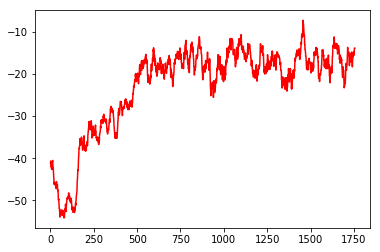

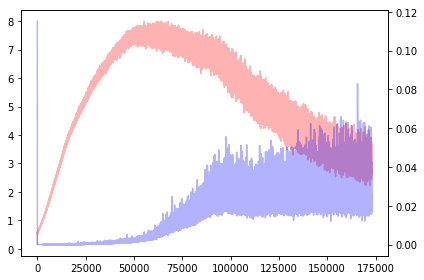

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd



plt.figure()
# plt.plot(len_mem, 'o')
plt.plot(pd.Series(cum_reward_mem).rolling(20).mean().dropna().values, color='red')
plt.show()

# plt.figure()
# plt.plot(a_loss, color='red', label='actor loss')
# plt.plot(c_loss, color='blue', label='critic loss')
# plt.legend()
# plt.show()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(a_loss, color='red', label='actor loss', alpha=0.3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(c_loss, color='blue', label='critic loss', alpha=0.3)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [28]:
env._max_episode_steps = 100
while True:
    try:
    #     env.seed = random.randint(0, 100000)

        

        old_state = env.reset()
        state, *_ = env.step([0])
        shift_state = np.concatenate((state, state - old_state))
        for t in count():

            if t % 500 == 0:
                print(t)

            env.render()

            if t == 0:
                time.sleep(0.1)

            global EPS
            EPS = 0.0

            policy_actor.eval()
            action = get_model_action(policy_actor, shift_state, device, train=False)
            old_state = state
            old_shift_state = shift_state
            state, reward, done, info = env.step(action)
            shift_state = np.concatenate((state, state - old_state))
    #         state, reward, done, info = env.step(action)

            print(action, reward, state)

            if done:
#                 env.close()

                break

        print(t)
#         assert False
    except KeyboardInterrupt:
        env.close()
        break
    finally:
#         env.close()
        print(t)

0
[0.3170195] -1.6588135436607758 [ 0.25797969 -0.96615034 -2.08581737]
[0.7829101] -2.151424780673765 [ 0.12594548 -0.99203716 -2.69299361]
[0.42687856] -2.81202866517593 [-0.04235597 -0.99910258 -3.3729897 ]
[0.226854] -3.7400586278941446 [-0.24428576 -0.96970329 -4.08828853]
[-0.32277839] -4.975109357369897 [-0.47061019 -0.88234123 -4.86398276]
[-0.87678977] -6.613409749991376 [-0.69817492 -0.71592722 -5.65725715]
[-0.98758729] -8.694086139185668 [-0.88660938 -0.46251897 -6.34234065]
[-0.995657] -11.10315521710046 [-0.99036816 -0.13845905 -6.83857843]
[-0.99535213] -13.69373751772682 [-0.97683088  0.21401267 -7.09172554]
[-0.99267276] -13.591201703638786 [-0.84206994  0.53936835 -7.08011695]
[-0.99443436] -11.628494143375626 [-0.61301551  0.79007088 -6.82475584]
[-0.98954394] -9.634588356822611 [-0.33427889  0.9424742  -6.38063428]
[0.21625093] -7.725649605311113 [-0.05873912  0.99827337 -5.64134099]
[-0.79243997] -5.838596818548398 [ 0.1906283   0.98166229 -5.01150196]
[0.96621426]

[1.] -10.169596580237444 [-0.99746604 -0.07114414  3.03802518]
[1.] -10.351244363173231 [-0.97413449 -0.225969    3.13466707]
[1.] -9.472999245310007 [-0.92728694 -0.37435135  3.11519032]
[1.] -8.57742859456537 [-0.861328   -0.50804929  2.98442681]
[0.99984668] -7.696860836161043 [-0.78345711 -0.62144586  2.75336684]
[1.] -6.864972584836074 [-0.70210215 -0.71207624  2.43728244]
[1.] -6.113501217327807 [-0.62543125 -0.78027928  2.05322526]
[0.99992239] -5.469247519695119 [-0.56032977 -0.82826961  1.61800416]
[1.] -4.952531401008533 [-0.51194183 -0.85902012  1.14680195]
[1.] -4.577191852156314 [-0.48364723 -0.87526302  0.65253686]
[0.98220781] -4.3517156211623655 [-0.4773583  -0.87870874  0.14342076]
[-0.24964699] -4.280572548591893 [-0.50147154 -0.86517414 -0.55305784]
[-1.] -4.42520207327655 [-0.55876486 -0.82932613 -1.35193845]
[-1.] -4.8653370352138205 [-0.64352323 -0.76542658 -2.12393305]
[-1.] -5.604503870163833 [-0.74563849 -0.66635069 -2.84800298]
[-1.] -6.631249591450925 [-0.850

[-0.99766195] -10.420771572527713 [-0.75421312  0.65662971 -5.4358029 ]
[-0.9965849] -8.837632133077808 [-0.56448896  0.82544062 -5.09281835]
[-0.99846379] -7.306226031348085 [-0.36034586  0.93281877 -4.62350745]
[-0.99830442] -5.900086701937415 [-0.1642096   0.98642547 -4.07363904]
[-0.99976194] -4.673291537717078 [ 0.0092324   0.99995738 -3.48378423]
[-0.99795359] -3.6531526631316145 [ 0.15280698  0.98825605 -2.88350923]
[-0.99644551] -2.8414451501638913 [ 0.26480065  0.96430318 -2.29178402]
[-0.99731058] -2.2235076159715503 [ 0.34656329  0.93802659 -1.71815322]
[-0.99872335] -1.7770273603539797 [ 0.40055909  0.91627093 -1.16444178]
[-0.99302432] -1.479093310099611 [ 0.42904617  0.90328256 -0.62619223]
[-0.97175008] -1.3110960303713675 [ 0.43330905  0.9012454  -0.09449283]
[-0.86219835] -1.2619459173451004 [0.41282691 0.9108095  0.45211147]
[-0.32411975] -1.3321218075914332 [0.36275781 0.93188345 1.08660063]
[0.69448655] -1.5575223604626034 [0.27322237 0.9619509  1.8896862 ]
[0.99099

[-0.40759561] -0.044830323692377654 [ 0.98581285  0.16784823 -0.26555993]
[-0.92885235] -0.03635662519468564 [ 0.98805835  0.15408018 -0.27900161]
[-0.04415463] -0.0317171297967132 [ 0.98933279  0.14567302 -0.17006467]
[-0.99076897] -0.025246277738002653 [ 0.99080391  0.13530566 -0.20942525]
[-0.16833341] -0.022834677456288248 [ 0.99168304  0.12870415 -0.13319602]
[-0.97679024] -0.01938527544910371 [ 0.99282026  0.11961573 -0.18318645]
[0.11401152] -0.01774541385238625 [ 0.99326979  0.11582364 -0.07637292]
[-0.99590335] -0.015050642724085605 [ 0.99405018  0.10892311 -0.13889069]
[-0.06577444] -0.013844851019376415 [ 0.99440983  0.10558922 -0.06706453]
[-0.98255608] -0.012605948057400732 [ 0.99510117  0.09886187 -0.13525602]
[0.30431113] -0.011727701388897829 [ 0.9951773   0.09809248 -0.01546296]
[-0.99412458] -0.010665348867935723 [ 0.99561338  0.09356281 -0.09101229]
[-0.12580651] -0.009623813888355906 [ 0.99579719  0.09158578 -0.03971116]
[-0.96770568] -0.009505664348677473 [ 0.99631

[-0.99007176] -0.007728139980543361 [ 0.99698117  0.07764368 -0.08844712]
[0.23438482] -0.006877920684869094 [0.99696195 0.0778901  0.00494336]
[-0.98698888] -0.0070557676577588675 [ 0.99728283  0.07366791 -0.08468739]
[0.25668694] -0.006219890666049997 [0.99724933 0.07412    0.00906658]
[-0.98399752] -0.006480336123183208 [ 0.99754814  0.06998363 -0.08294305]
[0.28687816] -0.005675979372287698 [0.99750394 0.0706109  0.0125764 ]
[-0.98282162] -0.005975961982463835 [ 0.99778469  0.0665261  -0.08188867]
[0.32640068] -0.005209379462857546 [0.99772789 0.0673725  0.01696601]
[-0.98220044] -0.005539440148066729 [ 0.99798888  0.06338931 -0.07983468]
98
98
0
[0.91007478] -2.161693780369122 [0.04710085 0.99889014 2.08884339]
[1.] -2.7589214652759715 [-0.10210402  0.99477373  2.98801099]
[1.] -3.6930129640378255 [-0.29216214  0.9563688   3.88409129]
[1.] -4.996362921219183 [-0.50902806  0.86074993  4.75136789]
[1.] -6.688949757830437 [-0.72525296  0.68848249  5.54693033]
[1.] -8.752711275326162 

[0.77077399] -5.657928659303548 [-0.72828176 -0.68527781 -0.18237266]
[-0.79282377] -5.6998502056125115 [-0.75560285 -0.65503003 -0.81525458]
[-0.99758716] -5.959585715716818 [-0.80125046 -0.59832909 -1.45616518]
[-0.99801971] -6.463930529650896 [-0.85838487 -0.51300625 -2.05461495]
[-0.99958901] -7.198280251336151 [-0.91743227 -0.39789198 -2.58930799]
[-1.] -8.13732307400043 [-0.96707253 -0.25450093 -3.03772697]
[-1.] -9.242740298360221 [-0.99609513 -0.08828638 -3.37860267]
[-1.] -10.464471981310508 [-0.99583146  0.09121245 -3.59481746]
[-1.] -10.597316171756464 [-0.96238179  0.27170073 -3.67640812]
[-0.99979972] -9.569034542489318 [-0.8976934   0.44062064 -3.62260253]
[-1.] -8.524175618195088 [-0.808971    0.58784856 -3.44213705]
[-1.] -7.501984225072633 [-0.70670988  0.70750346 -3.15125063]
[-1.] -6.543046477070333 [-0.60224144  0.798314   -2.77062303]
[-0.94134308] -5.6840634313321505 [-0.50609528  0.86247758 -2.31308899]
[-0.74707215] -4.9516787767366335 [-0.42751022  0.90401051 -

[0.99932172] -4.083616666102844 [ 0.44512441  0.89546874 -3.99269501]
[-0.77932902] -2.825721524550845 [ 0.59173777  0.80613052 -3.43799281]
[0.92052007] -2.061889622912229 [ 0.69468269  0.71931631 -2.69531691]
[-0.9798679] -1.3719496435920693 [ 0.77272251  0.63474398 -2.30280986]
[-0.06907795] -1.0031979675059264 [ 0.82768777  0.56118887 -1.83711357]
[-0.9861951] -0.6934744391879488 [ 0.86900231  0.49480804 -1.56415118]
[-0.55403514] -0.5128880144357033 [ 0.89878493  0.43838983 -1.27615043]
[-0.944462] -0.36968824448753124 [ 0.92131197  0.3888242  -1.08902735]
[-0.57594045] -0.2784142032839813 [ 0.93758912  0.34774509 -0.88380027]
[-0.94318739] -0.20514208147729068 [ 0.95019307  0.31166189 -0.76446956]
[-0.65820079] -0.1593265369869523 [ 0.95952972  0.28160738 -0.62945326]
[-0.91858957] -0.12195742538411841 [ 0.9669871   0.25482533 -0.55603616]
[-0.61621028] -0.09768965300310091 [ 0.97256098  0.23264812 -0.45734871]
[-0.90685197] -0.07687003069251894 [ 0.97722001  0.21222876 -0.418890

In [100]:
# torch.save(policy_actor, 'pendulum_actor.torch')
# torch.save(policy_critic, 'pendulum_critic.torch')

In [12]:
policy_actor = torch.load('pendulum_actor.torch').to(device)
policy_critic = torch.load('pendulum_critic.torch').to(device)

In [48]:
model = policy_net

NameError: name 'policy_net' is not defined

In [21]:
model.to('cpu')

Qnet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [22]:
torch.save(model, 'cart.torch')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
model = torch.load('cart.torch')

In [24]:
model.to(device)

Qnet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [25]:
policy_net = model